In this notebook, I figure out the car park locations have impact on the venues in Istanbul, the most crowded city in Turkey.

In [1]:
import types
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import requests
from pandas.io.json import json_normalize
import json
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



First, I need the location data of the car parks in Istanbul. For this reason, I used api that was developed by Istanbul Metropolitan Municipality. This data contains id, the name of parks (ParkAdi), borough (Ilce), latitude, longitude, capacity (Kapasitesi), free capacity (BosKapasite), type of park (ParkTipi), distance and free parking time in minutes (UcretsizParklanmaDK).

In [2]:
#car parking area data
url = "https://api.ibb.gov.tr/ispark/Park"
df = pd.read_json(url) 
df.head()

,ParkID,ParkAdi,Latitude,Longitude,Kapasitesi,BosKapasite,ParkTipi,Ilce,Distance,UcretsizParklanmaDk
0,395,Yeşil Vadi Sokak 4,40.967072,29.105824,40,27,YOL ÜSTÜ,ATAŞEHİR,0.372,15
1,1189,İçerenköy Açık Otoparkı 1,40.976597,29.104545,600,600,AÇIK OTOPARK,ATAŞEHİR,0.696,15
2,2151,Bostancı Vergi Dairesi Açık Otoparkı,40.962531,29.108000,105,105,AÇIK OTOPARK,ATAŞEHİR,0.907,0
3,2150,Bostancı Vergi Dairesi Açık Otoparkı,40.962510,29.108060,105,0,AÇIK OTOPARK,ATAŞEHİR,0.911,0
4,1176,Kozyatağı Sebze-Meyve Hali,40.978484,29.102947,1500,1500,AÇIK OTOPARK,ATAŞEHİR,0.918,0


The other data that I need is boroughs and their neighbourhoods in Istanbul. I found this data on one of repository and it is free to use. The data is in an excel file with many sheets so I create a new file to use in my work. In the end, I created a file with borough (ILCE), neighbourhood (SEMT_ADI_BUYUK) and postal code (POSTA_KODU). However, some rows has NaN cell so I cleaned the data. Also, I changed the type of POSTA_KODU column from float to int.

In [3]:
#data of towns and neighborhoods of Istanbul
df2 = pd.read_excel("il_ilce_semt.xls")
df2.head()

,ILCE,SEMT_ADI_BUYUK,POSTA_KODU
0,BAKIRKÖY,ZEYTİNLİK,34140.0
1,BAKIRKÖY,CEVİZLİK,34142.0
2,BAKIRKÖY,KARTALTEPE,34144.0
3,BAKIRKÖY,ZUHURATBABA,34147.0
4,BAKIRKÖY,YEŞİLKÖY,34149.0


In [4]:
#drop the row with Null postal code
print (df2[df2['SEMT_ADI_BUYUK'] == 'REŞADİYE'])
df2 = df2.dropna()

         ILCE SEMT_ADI_BUYUK  POSTA_KODU
217  ÜMRANİYE       REŞADİYE         NaN


In [5]:
print (df2[df2['SEMT_ADI_BUYUK'] == 'REŞADİYE'])

Empty DataFrame
Columns: [ILCE, SEMT_ADI_BUYUK, POSTA_KODU]
Index: []


In [6]:
# type casting for postal code column
df2 = df2.astype({'POSTA_KODU': 'int32'})
df2.head()

,ILCE,SEMT_ADI_BUYUK,POSTA_KODU
0,BAKIRKÖY,ZEYTİNLİK,34140
1,BAKIRKÖY,CEVİZLİK,34142
2,BAKIRKÖY,KARTALTEPE,34144
3,BAKIRKÖY,ZUHURATBABA,34147
4,BAKIRKÖY,YEŞİLKÖY,34149


First, I created Istanbul map and added all car parking area on the map.

In [7]:
address = 'Istanbul'

geolocator = Nominatim(user_agent="istanbul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Istanbul are 41.0096334, 28.9651646.


In [8]:
ist_map = folium.Map(location=[latitude, longitude], zoom_start = 10)

# add the car parking areas in Istanbul as markers to map
for lat, lng, borough, park in zip(df['Latitude'], df['Longitude'], df['Ilce'], df['ParkAdi']):
    label = '{}, {}'.format(park, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(ist_map)  
    
ist_map

I grouped the car parking data by borough (Ilce) to see how many parking area in each borough.

In [9]:
df.groupby('Ilce').count()

,ParkID,ParkAdi,Latitude,Longitude,Kapasitesi,BosKapasite,ParkTipi,Distance,UcretsizParklanmaDk
Ilce,,,,,,,,,
ARNAVUTKÖY,1,1,1,1,1,1,1,1,1
ATAŞEHİR,18,18,18,18,18,18,18,18,18
AVCILAR,7,7,7,7,7,7,7,7,7
BAHÇELİEVLER,10,10,10,10,10,10,10,10,10
BAKIRKÖY,40,40,40,40,40,40,40,40,40
BAYRAMPAŞA,11,11,11,11,11,11,11,11,11
BAĞCILAR,3,3,3,3,3,3,3,3,3
BAŞAKŞEHİR,4,4,4,4,4,4,4,4,4
BEYKOZ,13,13,13,13,13,13,13,13,13


I chose Kadikoy, one of the most crowded borough in Istanbul.
I created a map similar with Istanbul map for Kadikoy.

In [10]:
kadikoy_data = df[df['Ilce'] == 'KADIKÖY'].reset_index(drop=True)
kadikoy_data.head()

,ParkID,ParkAdi,Latitude,Longitude,Kapasitesi,BosKapasite,ParkTipi,Ilce,Distance,UcretsizParklanmaDk
0,1208,Bostancı İdo ve Adalar İskelesi Önü Taksi Durağı,40.952526,29.093790,16,16,TAKSİ PARK,KADIKÖY,2.180,0
1,1456,Bostancı Sahil-Cep Açık Otoparkı,40.954523,29.088487,195,40,AÇIK OTOPARK,KADIKÖY,2.224,15
2,1455,Bostancı Açık,40.952291,29.090255,375,0,AÇIK OTOPARK,KADIKÖY,2.344,15
3,458,Kazım Özalp Sokak 8,40.963544,29.077394,40,40,YOL ÜSTÜ,KADIKÖY,2.421,15
4,1753,Optimum AVM Önü Taksi Durağı,40.988228,29.085491,5,5,TAKSİ PARK,KADIKÖY,2.564,0


In [11]:
kadikoy_map = folium.Map(location=[latitude, longitude], zoom_start = 12.4)

# add the car parking areas in Kadikoy as markers to map
for lat, lng, borough, park in zip(kadikoy_data['Latitude'], kadikoy_data['Longitude'], kadikoy_data['Ilce'], kadikoy_data['ParkAdi']):
    label = '{}, {}'.format(park, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(kadikoy_map)  
    
kadikoy_map

However, there is no longitude and latitude data in my excel file so I decide to get this data with geopy.

In [12]:
#format the name of one neighborhood and add 2 new column to use in the future
kadikoy_data2 = df2[df2['ILCE'] == 'KADIKÖY'].reset_index(drop=True)
kadikoy_data2['SEMT_ADI_BUYUK'].values[12] = '19 MAYIS'
kadikoy_data2['LATITUDE'] = np.nan
kadikoy_data2['LONGITUDE']=np.nan
kadikoy_data2

,ILCE,SEMT_ADI_BUYUK,POSTA_KODU,LATITUDE,LONGITUDE
0,KADIKÖY,CAFERAĞA,34710,NaN,NaN
1,KADIKÖY,OSMANAĞA,34714,NaN,NaN
2,KADIKÖY,RASİMPAŞA,34716,NaN,NaN
3,KADIKÖY,KOŞUYOLU,34718,NaN,NaN
4,KADIKÖY,FİKİRTEPE,34720,NaN,NaN
5,KADIKÖY,EĞİTİM,34722,NaN,NaN
6,KADIKÖY,FENERYOLU,34724,NaN,NaN
7,KADIKÖY,FENERBAHÇE,34726,NaN,NaN
8,KADIKÖY,CADDEBOSTAN,34728,NaN,NaN
9,KADIKÖY,GÖZTEPE,34730,NaN,NaN


In [13]:
geolocator = Nominatim(user_agent="istanbul_explorer")

#add latitude and longitude information of neighborhoods in Kadikoy
for index in range(17):
    address = kadikoy_data2['SEMT_ADI_BUYUK'].values[index]
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    kadikoy_data2['LATITUDE'][index] = latitude
    kadikoy_data2['LONGITUDE'][index] = longitude
    print('The geograpical coordinates of '+address+' are {}, {}.'.format(latitude, longitude))

/Users/nagihan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/nagihan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


The geograpical coordinates of CAFERAĞA are 40.9850403, 29.0248102.
The geograpical coordinates of OSMANAĞA are 41.4715467, 32.9354034.
The geograpical coordinates of RASİMPAŞA are 40.9970269, 29.0265413.
The geograpical coordinates of KOŞUYOLU are 37.490219, 41.027561.
The geograpical coordinates of FİKİRTEPE are 40.9941424, 29.0513335.
The geograpical coordinates of EĞİTİM are 40.9890334, 29.0490887.
The geograpical coordinates of FENERYOLU are 40.9787155, 29.0490586.
The geograpical coordinates of FENERBAHÇE are 40.9734335, 29.0430908.
The geograpical coordinates of CADDEBOSTAN are 40.9670186, 29.0629255.
The geograpical coordinates of GÖZTEPE are 41.0788619, 29.0883719.
The geograpical coordinates of MERDİVENKÖY are 39.882759, 40.819969.
The geograpical coordinates of SAHRAYICEDİT are 40.9831733, 29.0831882.
The geograpical coordinates of 19 MAYIS are 41.0391853, 28.5993001.
The geograpical coordinates of ERENKÖY are 35.1790022, 32.6097115.
The geograpical coordinates of SUADİYE ar

After getting latitude and longitude of neighbourhoods, I realized that some of them were wrong because there is another town with same name in Turkey. Thus, I updated those neighbourhoods.

In [14]:
#correct coordinates of some neighborhoods in Kadikoy

kadikoy_data2['LATITUDE'][3] = '41.006634' #kosuyolu
kadikoy_data2['LONGITUDE'][3] = '29.034012'
kadikoy_data2['LATITUDE'][13] = '40.971519' #erenkoy
kadikoy_data2['LONGITUDE'][13] = '29.076363'
kadikoy_data2['LATITUDE'][10] = '40.987392' #merdivenkoy
kadikoy_data2['LONGITUDE'][10] = '29.065334'
kadikoy_data2['LATITUDE'][9] = '40.976940' #goztepe
kadikoy_data2['LONGITUDE'][9] = '29.062500'
kadikoy_data2['LATITUDE'][1] = '40.980518' #osmanaga
kadikoy_data2['LONGITUDE'][1] = '29.108685'
kadikoy_data2['LATITUDE'][12] = '40.980141' #19 mayis
kadikoy_data2['LONGITUDE'][12] = '29.082270'
kadikoy_data2

/Users/nagihan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nagihan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/nagihan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

,ILCE,SEMT_ADI_BUYUK,POSTA_KODU,LATITUDE,LONGITUDE
0,KADIKÖY,CAFERAĞA,34710,40.985040,29.024810
1,KADIKÖY,OSMANAĞA,34714,40.980518,29.108685
2,KADIKÖY,RASİMPAŞA,34716,40.997027,29.026541
3,KADIKÖY,KOŞUYOLU,34718,41.006634,29.034012
4,KADIKÖY,FİKİRTEPE,34720,40.994142,29.051333
5,KADIKÖY,EĞİTİM,34722,40.989033,29.049089
6,KADIKÖY,FENERYOLU,34724,40.978715,29.049059
7,KADIKÖY,FENERBAHÇE,34726,40.973433,29.043091
8,KADIKÖY,CADDEBOSTAN,34728,40.967019,29.062925
9,KADIKÖY,GÖZTEPE,34730,40.976940,29.062500


After cleaning and correcting my data, I use Foursquare API to get the data of venues in Kadikoy, Istanbul.

In [45]:
#Foursquare ID & Secret
CLIENT_ID = 'my Foursquare ID' # my Foursquare ID
CLIENT_SECRET = 'my Foursquare Secret' # my Foursquare Secret
VERSION = 'Foursquare API version' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: my Foursquare ID
CLIENT_SECRET:my Foursquare Secret


In [46]:
search_query = 'Kadıköy'
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=my Foursquare ID&client_secret=my Foursquare Secret&v=Foursquare API version&ll=40.9581685,29.0968046&radius=500&limit=100'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef6f13c6e5c0a46488776bb'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bostancı',
  'headerFullLocation': 'Bostancı, Istanbul',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 52,
  'suggestedBounds': {'ne': {'lat': 40.9626685045, 'lng': 29.102752258463408},
   'sw': {'lat': 40.9536684955, 'lng': 29.09085694153659}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '50efc643e4b055eafeda64b3',
       'name': 'Bakıroğlu Gurme',
       'location': {'address': 'Ali Nihat Tarlan Cad. Bostanci',
        'lat': 40.95776765987196,
        'lng': 29.097471013753243,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.9

I grouped the venues by categories.

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Bakıroğlu Gurme,Breakfast Spot,40.957768,29.097471
1,Dondurmacı Yaşar Usta,Ice Cream Shop,40.957193,29.097021
2,Safranbolu Fırını,Bakery,40.958798,29.094185
3,Maya Yoga Bostancı,Yoga Studio,40.958613,29.098582
4,Studyo pilates,Athletics & Sports,40.958013,29.096092


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

52 venues were returned by Foursquare.


In [21]:
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(kadikoy_map) 

kadikoy_map

I got the venues for each neighbourhood in Kadikoy.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
kadikoy_venues = getNearbyVenues(names=kadikoy_data2['SEMT_ADI_BUYUK'],
                                   latitudes=kadikoy_data2['LATITUDE'],
                                   longitudes=kadikoy_data2['LONGITUDE']
                                  )

CAFERAĞA
OSMANAĞA
RASİMPAŞA
KOŞUYOLU
FİKİRTEPE
EĞİTİM
FENERYOLU
FENERBAHÇE
CADDEBOSTAN
GÖZTEPE
MERDİVENKÖY
SAHRAYICEDİT
19 MAYIS
ERENKÖY
SUADİYE
KOZYATAĞI
BOSTANCI


In [24]:
print(kadikoy_venues.shape)
kadikoy_venues.head()

(958, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CAFERAĞA,40.98504,29.02481,Oyun Atölyesi,40.986366,29.025825,Theater
1,CAFERAĞA,40.98504,29.02481,Kanca,40.985677,29.023551,Café
2,CAFERAĞA,40.98504,29.02481,Tribu Caffe Artigiano,40.984692,29.024847,Coffee Shop
3,CAFERAĞA,40.98504,29.02481,OD46,40.986721,29.025544,Creperie
4,CAFERAĞA,40.98504,29.02481,Muutto Istanbul,40.985790,29.022723,Restaurant


In [25]:
kadikoy_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
19 MAYIS,63,63,63,63,63,63
BOSTANCI,52,52,52,52,52,52
CADDEBOSTAN,91,91,91,91,91,91
CAFERAĞA,100,100,100,100,100,100
ERENKÖY,35,35,35,35,35,35
EĞİTİM,37,37,37,37,37,37
FENERBAHÇE,82,82,82,82,82,82
FENERYOLU,47,47,47,47,47,47
FİKİRTEPE,14,14,14,14,14,14


In [26]:
print('There are {} uniques categories.'.format(len(kadikoy_venues['Venue Category'].unique())))

There are 182 uniques categories.


In [27]:
# one hot encoding
kadikoy_onehot = pd.get_dummies(kadikoy_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kadikoy_onehot['Neighborhood'] = kadikoy_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kadikoy_onehot.columns[-1]] + list(kadikoy_onehot.columns[:-1])
kadikoy_onehot = kadikoy_onehot[fixed_columns]

kadikoy_onehot.head()

,Neighborhood,Accessories Store,Advertising Agency,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Trail,Train Station,Turkish Home Cooking Restaurant,Turkish Restaurant,Veterinarian,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,CAFERAĞA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CAFERAĞA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CAFERAĞA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CAFERAĞA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CAFERAĞA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
kadikoy_onehot.shape

(958, 183)

I examined the venues for each neighbourhood in Kadikoy.

In [29]:
kadikoy_grouped = kadikoy_onehot.groupby('Neighborhood').mean().reset_index()
kadikoy_grouped

,Neighborhood,Accessories Store,Advertising Agency,Arcade,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Trail,Train Station,Turkish Home Cooking Restaurant,Turkish Restaurant,Veterinarian,Waterfront,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,19 MAYIS,0.000000,0.000000,0.000000,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,BOSTANCI,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,...,0.00,0.000000,0.038462,0.019231,0.000000,0.000000,0.000000,0.00,0.000000,0.019231
2,CADDEBOSTAN,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.00,0.010989,0.010989
3,CAFERAĞA,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000
4,ERENKÖY,0.028571,0.000000,0.028571,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.057143,0.028571,0.057143,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
5,EĞİTİM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,FENERBAHÇE,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.012195,0.000000,0.000000,0.012195,0.00,0.000000,0.000000
7,FENERYOLU,0.000000,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.021277,0.000000,0.021277,0.000000,0.000000,0.000000,0.00,0.000000,0.021277
8,FİKİRTEPE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,GÖZTEPE,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.045455,0.000000,0.090909,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


In [30]:
kadikoy_grouped.shape

(17, 183)

I listed top 5 venues for each neighbourhood in Kadikoy.

In [31]:
num_top_venues = 5

for hood in kadikoy_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kadikoy_grouped[kadikoy_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----19 MAYIS----
                venue  freq
0                Park  0.11
1                Café  0.10
2      Ice Cream Shop  0.08
3              Bakery  0.05
4  Seafood Restaurant  0.05


----BOSTANCI----
                             venue  freq
0                             Café  0.23
1                     Dessert Shop  0.06
2                           Bakery  0.06
3                            Hotel  0.04
4  Turkish Home Cooking Restaurant  0.04


----CADDEBOSTAN----
                venue  freq
0         Coffee Shop  0.15
1                Café  0.07
2          Restaurant  0.04
3  Seafood Restaurant  0.04
4      Ice Cream Shop  0.04


----CAFERAĞA----
         venue  freq
0         Café  0.23
1  Coffee Shop  0.11
2  Pizza Place  0.05
3   Restaurant  0.05
4          Bar  0.04


----ERENKÖY----
           venue  freq
0         Bakery  0.09
1   Dessert Shop  0.09
2  Train Station  0.06
3    Art Gallery  0.06
4    Coffee Shop  0.06


----EĞİTİM----
            venue  freq
0            Café 

In [32]:
#function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kadikoy_grouped['Neighborhood']

for ind in np.arange(kadikoy_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kadikoy_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,19 MAYIS,Park,Café,Ice Cream Shop,Bakery,Seafood Restaurant,Gym / Fitness Center,Grocery Store,Pastry Shop,Pilates Studio,Department Store
1,BOSTANCI,Café,Dessert Shop,Bakery,Gym / Fitness Center,Hotel,Ice Cream Shop,Turkish Home Cooking Restaurant,Meyhane,Pastry Shop,Pet Store
2,CADDEBOSTAN,Coffee Shop,Café,Restaurant,Seafood Restaurant,Ice Cream Shop,Fast Food Restaurant,Chocolate Shop,Cosmetics Shop,Salon / Barbershop,Burger Joint
3,CAFERAĞA,Café,Coffee Shop,Pizza Place,Restaurant,Bar,Theater,Chocolate Shop,Dessert Shop,Art Gallery,Ice Cream Shop
4,ERENKÖY,Dessert Shop,Bakery,Art Gallery,Turkish Restaurant,Train Station,Farmers Market,Coffee Shop,Accessories Store,Flower Shop,Bridal Shop
5,EĞİTİM,Café,Grocery Store,Cigkofte Place,Coffee Shop,Restaurant,College Theater,Doner Restaurant,Food & Drink Shop,Scenic Lookout,Flower Shop
6,FENERBAHÇE,Café,Restaurant,Seafood Restaurant,Dessert Shop,Coffee Shop,Kebab Restaurant,Gym / Fitness Center,Steakhouse,Sushi Restaurant,Pool
7,FENERYOLU,Café,Seafood Restaurant,Gym,Restaurant,Dance Studio,Kebab Restaurant,Pub,Manti Place,Flower Shop,Flea Market
8,FİKİRTEPE,Café,Fast Food Restaurant,Restaurant,Business Service,Garden,Steakhouse,Theater,Bakery,Comedy Club,Park
9,GÖZTEPE,Café,Turkish Restaurant,Bakery,Park,Dessert Shop,Paper / Office Supplies Store,Salon / Barbershop,Snack Place,Fish Market,Farmers Market


Before clustering the data, I had to find the best k so I used elbow method for this purpose.

In [34]:
#find k for clustering 
kadikoy_grouped_clustering = kadikoy_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(kadikoy_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

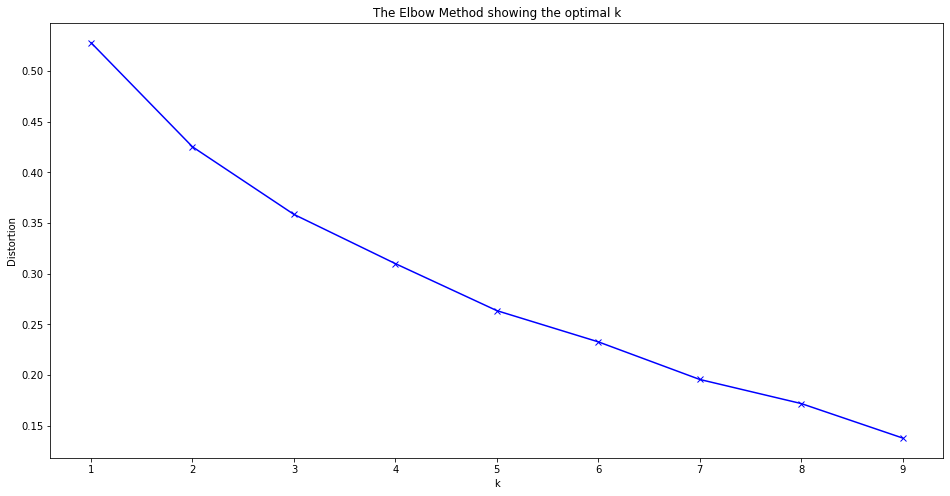

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kadikoy_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kadikoy_merged = kadikoy_data2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kadikoy_merged = kadikoy_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='SEMT_ADI_BUYUK')

kadikoy_merged # check the last columns!

,ILCE,SEMT_ADI_BUYUK,POSTA_KODU,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,KADIKÖY,CAFERAĞA,34710,40.985040,29.024810,1,Café,Coffee Shop,Pizza Place,Restaurant,Bar,Theater,Chocolate Shop,Dessert Shop,Art Gallery,Ice Cream Shop
1,KADIKÖY,OSMANAĞA,34714,40.980518,29.108685,0,Restaurant,Café,Bakery,Turkish Restaurant,Doner Restaurant,Steakhouse,Italian Restaurant,Comfort Food Restaurant,Ice Cream Shop,Burger Joint
2,KADIKÖY,RASİMPAŞA,34716,40.997027,29.026541,1,Café,Coffee Shop,Breakfast Spot,Burger Joint,Bar,Seafood Restaurant,Plaza,Bookstore,Boat or Ferry,Sporting Goods Shop
3,KADIKÖY,KOŞUYOLU,34718,41.006634,29.034012,0,Café,Hookah Bar,Park,Gym,Restaurant,Turkish Restaurant,Breakfast Spot,Coffee Shop,Electronics Store,Pharmacy
4,KADIKÖY,FİKİRTEPE,34720,40.994142,29.051333,0,Café,Fast Food Restaurant,Restaurant,Business Service,Garden,Steakhouse,Theater,Bakery,Comedy Club,Park
5,KADIKÖY,EĞİTİM,34722,40.989033,29.049089,0,Café,Grocery Store,Cigkofte Place,Coffee Shop,Restaurant,College Theater,Doner Restaurant,Food & Drink Shop,Scenic Lookout,Flower Shop
6,KADIKÖY,FENERYOLU,34724,40.978715,29.049059,0,Café,Seafood Restaurant,Gym,Restaurant,Dance Studio,Kebab Restaurant,Pub,Manti Place,Flower Shop,Flea Market
7,KADIKÖY,FENERBAHÇE,34726,40.973433,29.043091,0,Café,Restaurant,Seafood Restaurant,Dessert Shop,Coffee Shop,Kebab Restaurant,Gym / Fitness Center,Steakhouse,Sushi Restaurant,Pool
8,KADIKÖY,CADDEBOSTAN,34728,40.967019,29.062925,0,Coffee Shop,Café,Restaurant,Seafood Restaurant,Ice Cream Shop,Fast Food Restaurant,Chocolate Shop,Cosmetics Shop,Salon / Barbershop,Burger Joint
9,KADIKÖY,GÖZTEPE,34730,40.976940,29.062500,0,Café,Turkish Restaurant,Bakery,Park,Dessert Shop,Paper / Office Supplies Store,Salon / Barbershop,Snack Place,Fish Market,Farmers Market


In [40]:
kadikoy_merged.shape

(17, 16)

In [41]:
kadikoy_map2 = folium.Map(location=[latitude, longitude], zoom_start = 12.4)

# add markers to map
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kadikoy_merged['LATITUDE'], kadikoy_merged['LONGITUDE'], kadikoy_merged['SEMT_ADI_BUYUK'], kadikoy_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(kadikoy_map2)
       
kadikoy_map2


In [42]:

for lat, lng, borough, park in zip(kadikoy_data['Latitude'], kadikoy_data['Longitude'], kadikoy_data['Ilce'], kadikoy_data['ParkAdi']):
    label = '{}, {}'.format(park, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(kadikoy_map2)  
    
kadikoy_map2

I examined the each cluster.

In [43]:
kadikoy_merged.loc[kadikoy_merged['Cluster Labels'] == 0, kadikoy_merged.columns[[1] + list(range(5, kadikoy_merged.shape[1]))]]

,SEMT_ADI_BUYUK,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,OSMANAĞA,0,Restaurant,Café,Bakery,Turkish Restaurant,Doner Restaurant,Steakhouse,Italian Restaurant,Comfort Food Restaurant,Ice Cream Shop,Burger Joint
3,KOŞUYOLU,0,Café,Hookah Bar,Park,Gym,Restaurant,Turkish Restaurant,Breakfast Spot,Coffee Shop,Electronics Store,Pharmacy
4,FİKİRTEPE,0,Café,Fast Food Restaurant,Restaurant,Business Service,Garden,Steakhouse,Theater,Bakery,Comedy Club,Park
5,EĞİTİM,0,Café,Grocery Store,Cigkofte Place,Coffee Shop,Restaurant,College Theater,Doner Restaurant,Food & Drink Shop,Scenic Lookout,Flower Shop
6,FENERYOLU,0,Café,Seafood Restaurant,Gym,Restaurant,Dance Studio,Kebab Restaurant,Pub,Manti Place,Flower Shop,Flea Market
7,FENERBAHÇE,0,Café,Restaurant,Seafood Restaurant,Dessert Shop,Coffee Shop,Kebab Restaurant,Gym / Fitness Center,Steakhouse,Sushi Restaurant,Pool
8,CADDEBOSTAN,0,Coffee Shop,Café,Restaurant,Seafood Restaurant,Ice Cream Shop,Fast Food Restaurant,Chocolate Shop,Cosmetics Shop,Salon / Barbershop,Burger Joint
9,GÖZTEPE,0,Café,Turkish Restaurant,Bakery,Park,Dessert Shop,Paper / Office Supplies Store,Salon / Barbershop,Snack Place,Fish Market,Farmers Market
10,MERDİVENKÖY,0,Café,Park,Turkish Restaurant,Breakfast Spot,Bakery,Furniture / Home Store,Grocery Store,Coffee Shop,Food,Restaurant
11,SAHRAYICEDİT,0,Café,Bakery,Restaurant,Turkish Restaurant,Ice Cream Shop,Park,Seafood Restaurant,Convenience Store,Farmers Market,Pool


In [44]:
kadikoy_merged.loc[kadikoy_merged['Cluster Labels'] == 1, kadikoy_merged.columns[[1] + list(range(5, kadikoy_merged.shape[1]))]]

,SEMT_ADI_BUYUK,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CAFERAĞA,1,Café,Coffee Shop,Pizza Place,Restaurant,Bar,Theater,Chocolate Shop,Dessert Shop,Art Gallery,Ice Cream Shop
2,RASİMPAŞA,1,Café,Coffee Shop,Breakfast Spot,Burger Joint,Bar,Seafood Restaurant,Plaza,Bookstore,Boat or Ferry,Sporting Goods Shop
16,BOSTANCI,1,Café,Dessert Shop,Bakery,Gym / Fitness Center,Hotel,Ice Cream Shop,Turkish Home Cooking Restaurant,Meyhane,Pastry Shop,Pet Store
